# Import Required Libraries
Import the necessary libraries, including geopandas, matplotlib, and pandas.

In [ ]:
# Import Required Libraries
import geopandas as gpd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import config
import os
import tempfile
import zipfile

# Load the active members data

In [2]:
active_members_extra_gender_df = pd.read_csv(config.ACTIVE_MEMBERS_EXTRA_GENDER)

# Group by Country and Count Members
Group the active members by country and count the number of members in each country.

In [3]:
# Group by Country and Count Members
country_distribution = active_members_extra_gender_df['country'].value_counts().reset_index()
country_distribution.columns = ['country', 'count']

# Read Shapefile from Zip File
Read the shapefile from the zip file and load it into a GeoDataFrame.

In [4]:
# Read the shapefile from the zip file and load it into a GeoDataFrame
with zipfile.ZipFile(config.NE_50M_COUNTRIES_ZIP, 'r') as zip_ref:
    with tempfile.TemporaryDirectory() as tmpdirname:
        zip_ref.extractall(tmpdirname)
        shapefile_path = os.path.join(tmpdirname, 'ne_50m_admin_0_countries.shp')
        world_df = gpd.read_file(shapefile_path)
# world_df.head()

# Merge Country Distribution with World Map
Merge the country distribution DataFrame with the world map GeoDataFrame.

In [5]:
# Merge the filtered country distribution with the world map
merged_world_df = world_df.merge(country_distribution, how='left', left_on='NAME', right_on='country')
# merged_world_df.head()


# Plot the World Map
Plot the world map, showing the countries with counted members, and save the plot.

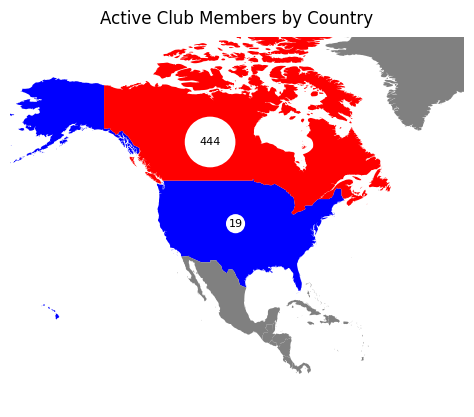

In [6]:
# Plot the Filtered Map

# Render Canada in red, the USA in blue, and other countries in grey
colors = {'Canada': config.CANADA_RED, 'United States of America': config.USA_BLUE}
world_df['color'] = world_df['NAME'].apply(lambda x: colors.get(x, 'grey'))

# Plot the map with the specified colors
world_df[world_df['CONTINENT'] == 'North America'].plot(color=world_df[world_df['CONTINENT'] == 'North America']['color'])

# Center the continent in the window
plt.xlim(-170, -30)
plt.ylim(0, 80)

# Plot circles over each country where count is not missing with a number in the middle of the circle
for idx, row in merged_world_df.dropna(subset=['count']).iterrows():
    if row['country'] == 'Canada':
        x_offset, y_offset = -10, -4
    elif row['country'] == 'United States of America':
        x_offset, y_offset = 12, -6
    else:
        x_offset, y_offset = 0, 0

    if row['country'] == 'Canada':
        size = row['count'] * 3  # Adjust the multiplier for Canada
    else:
        size = row['count'] * 10  # Adjust the multiplier for other countries
    plt.scatter(row['geometry'].centroid.x + x_offset, row['geometry'].centroid.y + y_offset, s=size, color='white', edgecolor='none', alpha=1.0)
    plt.text(row['geometry'].centroid.x + x_offset, row['geometry'].centroid.y + y_offset, str(int(row['count'])),
             ha='center', va='center', fontsize=8, color='black')
    
# Add a title and show the plot
plt.title('Active Club Members by Country', pad=10)

# Remove the axes
plt.axis('off')

# Save and show the plot
plt.savefig(config.CLUB_MEMBER_COUNTRY_DISTRIBUTION)
plt.show()